In [19]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import math

In [20]:
# Get data for a given ticker
ticker = "AMZN"
df = yf.Ticker(ticker).history("5y")
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-01-02 00:00:00-05:00,58.599998,59.500000,58.525501,59.450500,53890000,0.0,0.0
2018-01-03 00:00:00-05:00,59.415001,60.274502,59.415001,60.209999,62176000,0.0,0.0
2018-01-04 00:00:00-05:00,60.250000,60.793499,60.233002,60.479500,60442000,0.0,0.0
2018-01-05 00:00:00-05:00,60.875500,61.457001,60.500000,61.457001,70894000,0.0,0.0
2018-01-08 00:00:00-05:00,61.799999,62.653999,61.601501,62.343498,85590000,0.0,0.0


Set up the strategy by calculating rolling averages and the bands.

In [21]:
N = 50
std_factor = 1

# calculate rolling mean and std
df["SMA"] = df["Close"].rolling(window = N).mean()
df["Std"] = df["Close"].rolling(window = N).std()

# calculate upper and lower bollinger band
df["Upper"] = df["SMA"] + df["Std"] * std_factor
df["Lower"] = df["SMA"] - df["Std"] * std_factor

Let's plot a graph to visualise the strategy.

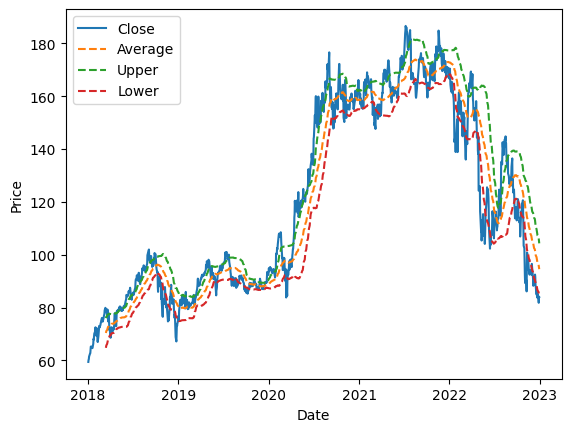

In [22]:
# plot the results
plt.plot(df["Close"], label="Close")
plt.plot(df["SMA"], label = "Average", ls = '--')
plt.plot(df["Upper"], label="Upper", ls = '--')
plt.plot(df["Lower"], label="Lower", ls = '--')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="upper left")
plt.show()

# Simple long strategy

Initialise variables for strategy.

In [23]:
starting_capital = 1000
df["Capital"] = starting_capital
df["shares_held"] = 0
df["Profit"] = 0

Execute Strategy.

In [24]:
trading_fee = 0.05 # percentage fee
counter = 0 # day number

# loop overall days
for t, row in df.iterrows():

    # do nothing for the first N days
    if counter < N:
        prev_row = row
        counter += 1
    else:
        
        # if previous close is above upper band, buy
        if(prev_row["Close"] > prev_row["Upper"] and prev_row["shares_held"] == 0):
            capital_yesturday = prev_row['Capital']
            df.loc[t, "shares_held"] = math.floor(capital_yesturday/row['Close']) 
            df.loc[t, "Capital"] = capital_yesturday - df.loc[t, "shares_held"] * row['Open'] * (1 + trading_fee)
            buy_price = row['Open'] * (1 + trading_fee)

        # if previous close is below lower band and we hold shares, sell
        elif(prev_row["Close"] < prev_row["Lower"] and prev_row["shares_held"] != 0):
            capital_yesturday = prev_row['Capital']
            df.loc[t, "Capital"] = capital_yesturday + prev_row["shares_held"] * row['Open'] * (1 - trading_fee)
            sell_price = row['Open'] * (1 - trading_fee)
            df.loc[t, "Profit"] = (sell_price - buy_price) * prev_row["shares_held"]
            df.loc[t, "shares_held"] = 0

        # do nothing
        else:
            df.loc[t, "Capital"] = prev_row["Capital"]
            df.loc[t, "shares_held"] = prev_row["shares_held"]

    prev_row = df.loc[t]


In [26]:
# find the cummulative profit
df["cum_profit"] = df["Profit"].cumsum()

Plot the capital and profit to see what it looks like.

<AxesSubplot: xlabel='Date', ylabel='Profit'>

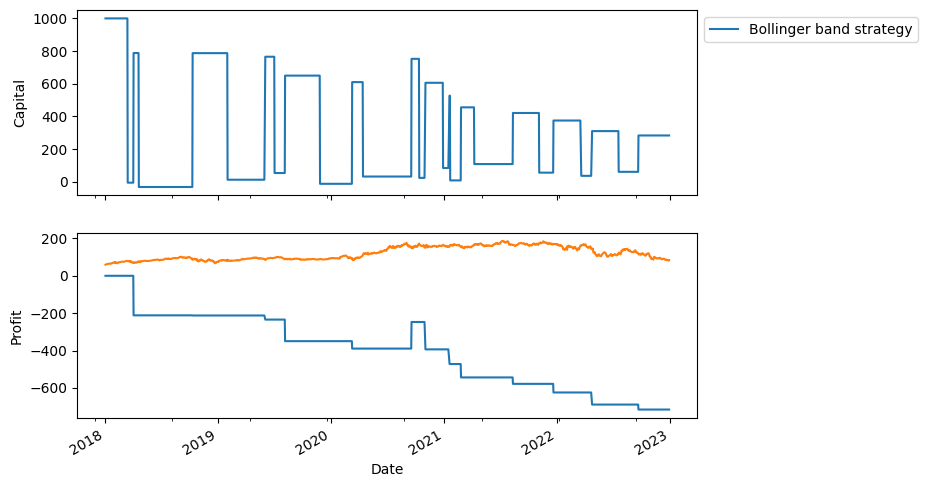

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# capital subplot
ax1.set_ylabel("Capital")
df.plot(y = "Capital", ax=ax1, label = "Bollinger band strategy")
ax1.legend(loc="upper left", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

# profit subplot
ax2.set_ylabel("Profit")
df.plot(y = "cum_profit", ax=ax2, legend = False)

Quite poor performance.

# Including short selling